In [6]:
import pandas as pd
import numpy as np


In [7]:
df_likes  = pd.read_csv('likes.csv')
df_likes.head(1)

,user_id,post_id,timestamp
0,128381,4704,1654030804


In [8]:
df_views = pd.read_csv('views.csv')
df_views.head(2)

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811


In [9]:
df_views['exp_group'].value_counts()

test       96917
control    96378
Name: exp_group, dtype: int64

In [10]:
users_in_two = df_views.groupby('user_id').exp_group.nunique().reset_index()
users_in_two = users_in_two[users_in_two['exp_group'] > 1]
users_in_two

,user_id,exp_group
10071,25623,2
20633,55788,2
54475,142283,2
57065,148670,2


In [11]:
df_views_1 = df_views[~df_views['user_id'].isin(users_in_two)]

In [12]:
likes_per_user = df_likes.groupby('user_id').size().reset_index(name='likes_count')
user_groups = df_views_1.groupby('user_id')['exp_group'].first().reset_index()
merged = user_groups.merge(likes_per_user, on='user_id', how='left')
merged['likes_count'] = merged['likes_count'].fillna(0)
merged.head()

,user_id,exp_group,likes_count
0,200,test,1.0
1,201,test,3.0
2,202,test,2.0
3,212,test,4.0
4,213,test,7.0


In [13]:
has_likes = (merged['likes_count'] > 0).sum()
total_users = len(merged)
proportion = (has_likes / total_users)*100

print(f'Пропорция пользователей с лайками: {proportion:.1f}')


Пропорция пользователей с лайками: 89.5


(array([1.5003e+04, 8.4070e+03, 4.5380e+03, 2.2030e+03, 1.4790e+03,
        4.5000e+02, 2.6200e+02, 1.4400e+02, 9.1000e+01, 3.2000e+01,
        2.4000e+01, 1.1000e+01, 7.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([ 0.  ,  2.25,  4.5 ,  6.75,  9.  , 11.25, 13.5 , 15.75, 18.  ,
        20.25, 22.5 , 24.75, 27.  , 29.25, 31.5 , 33.75, 36.  , 38.25,
        40.5 , 42.75, 45.  ]),
 <BarContainer object of 20 artists>)

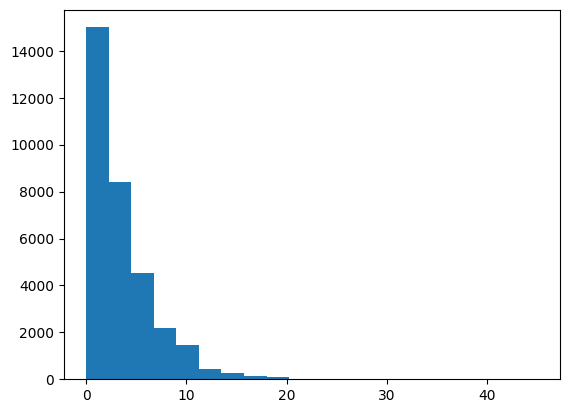

In [14]:
import matplotlib.pyplot as plt

plt.hist(merged[merged['exp_group'] == 'test'].likes_count,bins=20)

(array([9.4790e+03, 1.0559e+04, 6.0350e+03, 1.7780e+03, 2.1620e+03,
        1.0760e+03, 3.4100e+02, 4.1100e+02, 2.3400e+02, 7.4000e+01,
        8.2000e+01, 5.8000e+01, 2.7000e+01, 8.0000e+00, 1.4000e+01,
        4.0000e+00, 3.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ,
        18.7, 20.4, 22.1, 23.8, 25.5, 27.2, 28.9, 30.6, 32.3, 34. ]),
 <BarContainer object of 20 artists>)

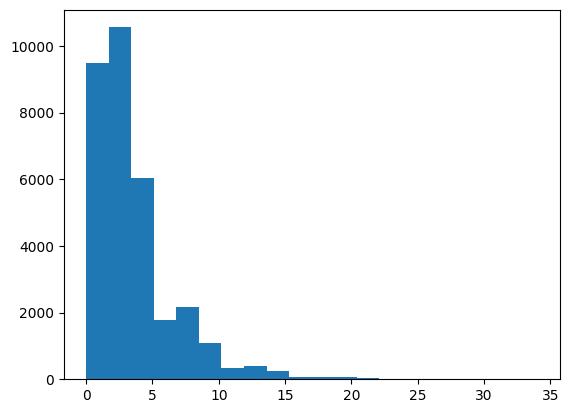

In [15]:
plt.hist(merged[merged['exp_group'] == 'control'].likes_count,bins=20)

In [16]:
from scipy.stats import mannwhitneyu

res = mannwhitneyu(
    merged[merged.exp_group == 'control'].likes_count,
    merged[merged.exp_group == 'test'].likes_count,
)

In [17]:
round(res.pvalue,3)

0.0

In [18]:
pivot = pd.merge(df_views, df_likes, on='user_id', how='outer')
pivot.post_id = pivot.post_id.fillna(-1).astype(int)
pivot.head()

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,[3644 4529 4704 5294 4808],1654030803,4704,1.654031e+09
1,128381,control,[3644 4529 4704 5294 4808],1654030803,5294,1.654031e+09
2,128381,control,[3644 4529 4704 5294 4808],1654030803,3608,1.655049e+09
3,128381,control,[3644 4529 4704 5294 4808],1654030803,2542,1.655049e+09
4,128381,control,[3644 4529 4704 5294 4808],1654030803,4165,1.655053e+09


In [19]:
pivot['recommendations'] = pivot.recommendations.apply(
    lambda x: list(map(int, filter(bool, x[1:-1].split(' '))))
)
pivot.head()

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,4704,1.654031e+09
1,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,5294,1.654031e+09
2,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,3608,1.655049e+09
3,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,2542,1.655049e+09
4,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,4165,1.655053e+09


In [20]:
pivot.post_id = pivot.apply(
    lambda row:
    -1
    if
        (row.post_id == -1) | 
        ((row.timestamp_x > row.timestamp_y) |
         (row.timestamp_x + 60 * 60 < row.timestamp_y)) |
        (row.post_id not in row.recommendations)
    else
    row.post_id, axis=1)

In [21]:
def my_agg(values):
    values = set(values)
    if -1 in values and len(values) >= 2:
        return 1
    elif -1 not in values:
        return 1
    return 0

agg = pivot.groupby(['user_id', 'exp_group', 'timestamp_x']).post_id.agg(my_agg)
agg.reset_index().post_id.mean()

0.7132672857549341

In [22]:
import hashlib

In [23]:
# bucket 
agg = agg.reset_index().rename(columns={'post_id': 'hitrate'})
agg['bucket'] = agg['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'bbb').encode()).hexdigest(), 16) % 100
)

In [24]:
agg.head()

,user_id,exp_group,timestamp_x,hitrate,bucket
0,200,test,1655009047,1,97
1,201,test,1654043283,0,39
2,201,test,1654173790,0,39
3,201,test,1654444704,1,39
4,201,test,1654517459,0,39


In [25]:
agg['view'] = 1

new_df = agg.groupby(['exp_group', 'bucket']).sum(['hitrate', 'view']).reset_index()
new_df['hitrate_new'] = new_df.hitrate / new_df.view

new_df.head()

,exp_group,bucket,user_id,timestamp_x,hitrate,view,hitrate_new
0,control,0,75055655,1472627637383,621,890,0.697753
1,control,1,78264361,1557009869357,666,941,0.707758
2,control,2,89756485,1664574067853,705,1006,0.700795
3,control,3,74901253,1523924072519,645,921,0.700326
4,control,4,77667488,1605003115000,710,970,0.731959


In [26]:
agg.groupby('exp_group').hitrate.mean().round(2)

exp_group
control    0.71
test       0.72
Name: hitrate, dtype: float64

In [27]:
man_test = mannwhitneyu(
    new_df[new_df.exp_group == 'control'].hitrate_new,
    new_df[new_df.exp_group == 'test'].hitrate_new,
)

In [28]:
round(man_test.pvalue,2)

0.0

In [29]:
from scipy.stats import ttest_ind
t_test = ttest_ind(
    new_df[new_df.exp_group == 'control'].hitrate_new,
    new_df[new_df.exp_group == 'test'].hitrate_new,
)

In [79]:
round(t_test.pvalue,2)

0.0